# Nearest Neighbor Methods

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Nearest-Neighbor-Methods" data-toc-modified-id="Nearest-Neighbor-Methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Nearest Neighbor Methods</a></span><ul class="toc-item"><li><span><a href="#The-Houses-dataset" data-toc-modified-id="The-Houses-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The Houses dataset</a></span><ul class="toc-item"><li><span><a href="#t-SNE" data-toc-modified-id="t-SNE-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>t-SNE</a></span></li></ul></li><li><span><a href="#The-OIL-dataset" data-toc-modified-id="The-OIL-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>The OIL dataset</a></span><ul class="toc-item"><li><span><a href="#K-NN" data-toc-modified-id="K-NN-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>K-NN</a></span></li><li><span><a href="#Distance-metrics" data-toc-modified-id="Distance-metrics-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Distance metrics</a></span></li></ul></li></ul></li></ul></div>

In [4]:
# Imports
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score

from dataset import Dataset

## The Houses dataset

We'll start re-using the houses dataset. If you remeber the main difficulty here is that the target variable is a SalePrice, so let's see if we can use a KNN to predict a binned version of it, using only numerical variables.

In [5]:
# Setup the dataset
houses = Dataset('./data/houseprices_prepared.csv.gz')
houses.set_target('SalePrice');

# remove de Id, scale numeric features and remove skenwess
houses.drop_columns('Id').scale().fix_skewness()

# Known issues with NA's
houses.replace_na(column='Electrical', value='Unknown')
houses.replace_na(column=houses.names('categorical_na'), value='None');

# Some FE basic stuff to reduce some features by aggregating them
houses.aggregate(['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2'], 'HouseSF')
houses.aggregate(['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch',
                  'WoodDeckSF'], 'HousePorch')
houses.aggregate(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], 
                  'HouseBaths');

My _k-NN_ problem will address the modeling using ONLY the numeric features, so I create a new Dataset called `subset` that will only contain numericals.

In [6]:
subset_df = pd.concat([houses.select('numerical'), houses.target], axis=1)
subset = Dataset.from_dataframe(subset_df).set_target('SalePrice')
subset.describe()

25 Features. 1460 Samples
Available types: [dtype('float64')]
  · 0 categorical features
  · 25 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 25 Complete features
--
Target: SalePrice (float64)
'SalePrice'
  · Min.: 34900.0000
  · 1stQ: 129975.0000
  · Med.: 163000.0000
  · Mean: 180921.1959
  · 3rdQ: 214000.0000
  · Max.: 755000.0000


I need to make my problem suitable for a classification algorithm like _k-NN_. 

So, given that my target variable is a continuous number, I must **discretize** it, so I decide to bin it, using the convenient method `KBinsDiscretizer` is Scikit Learn. I start by binning in 5 different buckets, but I can change that later. 

This means that my problem is now a classification problem where the `SalePrice` is now a value between 0 and 4.

In [7]:
saleprice_enc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
saleprice_enc.fit(subset.target.values.reshape(-1, 1))

y_enc = saleprice_enc.transform(subset.target.values.reshape(-1, 1))
subset.target = pd.Series(y_enc.ravel(), name='SalePrice')

I think I can go for KNN now.

In [8]:
X, y = subset.split()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X.train.values, y.train.values)

#Predict the response for test dataset
y_pred = knn.predict(X.test.values)
# Model Accuracy, how often is the classifier correct?
print("F1 (micro):", f1_score(y.test, y_pred, average='micro'))

F1 (micro): 0.773972602739726


Let's find the best value for K, using cross validation

In [9]:
tuned_parameters = [{'n_neighbors': [3,5,7,9,11,13,15,17,19]}]
clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, 
                   cv=5, scoring='f1_micro')
clf.fit(X.train, y.train)
print("Best parameters set found on development set:")
print(' ->', clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(" -> %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
y_true, y_pred = y.test, clf.predict(X.test)
print("\n",classification_report(y_true, y_pred))

Best parameters set found on development set:
 -> {'n_neighbors': 7}
Grid scores on development set:
 -> 0.723 (+/-0.068) for {'n_neighbors': 3}
 -> 0.748 (+/-0.050) for {'n_neighbors': 5}
 -> 0.769 (+/-0.023) for {'n_neighbors': 7}
 -> 0.763 (+/-0.039) for {'n_neighbors': 9}
 -> 0.760 (+/-0.038) for {'n_neighbors': 11}
 -> 0.760 (+/-0.039) for {'n_neighbors': 13}
 -> 0.758 (+/-0.037) for {'n_neighbors': 15}
 -> 0.767 (+/-0.032) for {'n_neighbors': 17}
 -> 0.761 (+/-0.029) for {'n_neighbors': 19}

               precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       118
         1.0       0.76      0.76      0.76       114
         2.0       0.66      0.62      0.64        40
         3.0       0.67      0.59      0.62        17
         4.0       0.00      0.00      0.00         3

   micro avg       0.77      0.77      0.77       292
   macro avg       0.58      0.57      0.58       292
weighted avg       0.76      0.77      0.77       292



### t-SNE

Plot the results using t-SNE. To know more about, refer to this [link](https://distill.pub/2016/misread-tsne/)

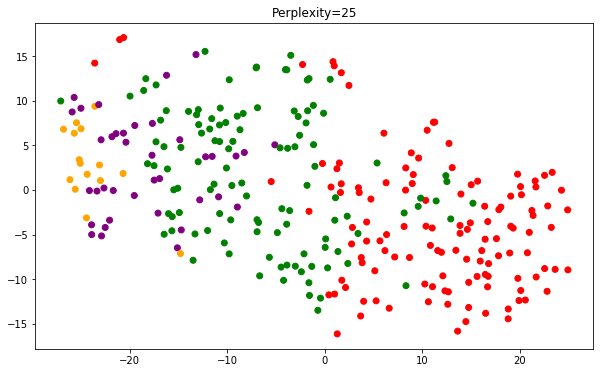

In [10]:
colors = ['red','green','blue','purple','orange']
perplexity=25
X_embedded = TSNE(n_components=2, perplexity=perplexity).fit_transform(X.test)
plt.figure(figsize=(10,6))
plt.scatter(X_embedded[:, :1], X_embedded[:, 1:2], 
            c=y_pred.reshape(-1,1), cmap=ListedColormap(colors))
plt.title("Perplexity={}".format(perplexity)); plt.show();

## The OIL dataset

Available [here](http://inverseprobability.com/3PhaseData.html).
Configuration labels, originally as dummy variables:

    [1 0 0] == Homogeneous configuration
    [0 1 0] == Annular configuration
    [0 0 1] == Stratified configuration

We convert them into a single categorical 3-valued character.

In [11]:
oil_dummy_labels = ['1','2','3']
oil_labels = Dataset('./data/DataTrnLbls.txt', 
                     header=None,
                     sep='  ', 
                     names=oil_dummy_labels)
# Transform the dummies into the actual category label (column name)
oil_labels.features['target'] = oil_labels.features.idxmax(axis=1)
oil_labels.drop_columns(oil_dummy_labels);

We read the actual values in the training set, setting the variable names as $x_1$, ... to $x_{12}$.

In [12]:
oil_data = Dataset('./data/DataTrn.txt', 
                     header=None,
                     sep='  ', 
                     names=['x{}'.format(i+1) for i in range(12)])

Finally, we merge both datasets to form a single one with the target variable properly set as 'Configuration'.

In [14]:
oil = Dataset.from_dataframe(
    pd.concat([oil_data.features, oil_labels.features], axis=1))
oil.set_target('target');
oil.features.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.3315,0.2156,0.6802,0.1434,0.6825,0.2720,0.6223,0.2092,0.7961,0.1530,0.5856,0.2573
1,0.0939,1.0089,0.0365,0.6944,0.0908,0.4961,0.0722,0.6521,-0.0130,0.6085,0.0631,0.6597
2,0.5184,0.2283,0.5300,0.6884,0.7456,0.6171,0.6136,0.5928,0.7678,0.6130,0.6705,0.5202


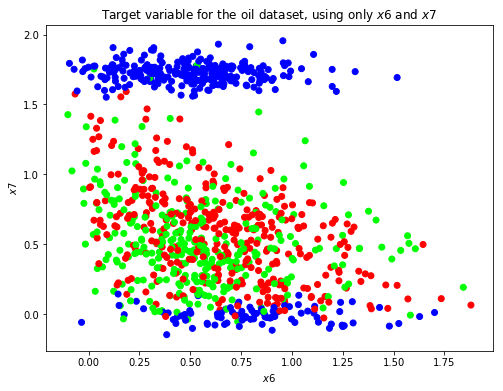

In [15]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x = oil.features.iloc[:, 5].values.reshape(-1,1)
y = oil.features.iloc[:, 6].values.reshape(-1,1)
plt.figure(figsize=(8,6))
plt.scatter(x, y,
            c=oil.target.values.reshape(-1, 1),
            cmap=cmap_bold)
plt.xlabel('$x6$')
plt.ylabel('$x7$')
plt.title('Target variable for the oil dataset, using only $x6$ and $x7$')
plt.show();

### K-NN

In [16]:
X, y = oil.split()
X.train = X.train.iloc[:, 5:7]
X.test = X.test.iloc[:, 5:7]
n_neighbors=7
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X.train.values, y.train.values)

#Predict the response for test dataset
y_pred = knn.predict(X.test.values)
# Model Accuracy, how often is the classifier correct?
print("F1:", f1_score(y.test, y_pred, average='micro'))

F1: 0.715


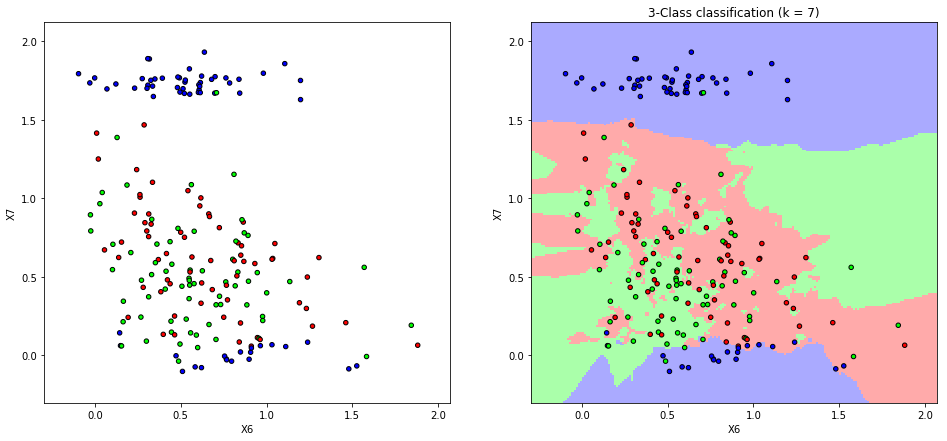

In [17]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
x_min, x_max = X.test.iloc[:, 0].min() - .2, X.test.iloc[:, 0].max() + .2
y_min, y_max = X.test.iloc[:, 1].min() - .2, X.test.iloc[:, 1].max() + .2
h = (x_max-x_min)/X.test.shape[0] # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape).astype(int)

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Plot the points with no KNN surface
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.scatter(X.test.iloc[:, 0], X.test.iloc[:, 1], 
            c=list(map(int, y.test.values)), 
            cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel("X6")
plt.ylabel("X7")

# Plot also the test points in the surface
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.scatter(X.test.iloc[:, 0], X.test.iloc[:, 1], 
            c=list(map(int, y.test.values)), 
            cmap=cmap_bold, edgecolor='k', s=20)
plt.xlabel("X6")
plt.ylabel("X7")
plt.title("3-Class classification (k = %i)" % n_neighbors)

plt.show()

Let's do cross_val_score to see if we can infer what is the best value for $k$.

In [18]:
f1 = []
min_k = 2
max_k = 21
for k in range(min_k, max_k):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    score = cross_val_score(knn, X.train, y.train, scoring='f1_micro', cv=5)
    f1.append(score)
f1_means = np.mean(np.array(f1), axis=1)

Let's plot the average F1_micro obtained per CV split, for each value of $k$.

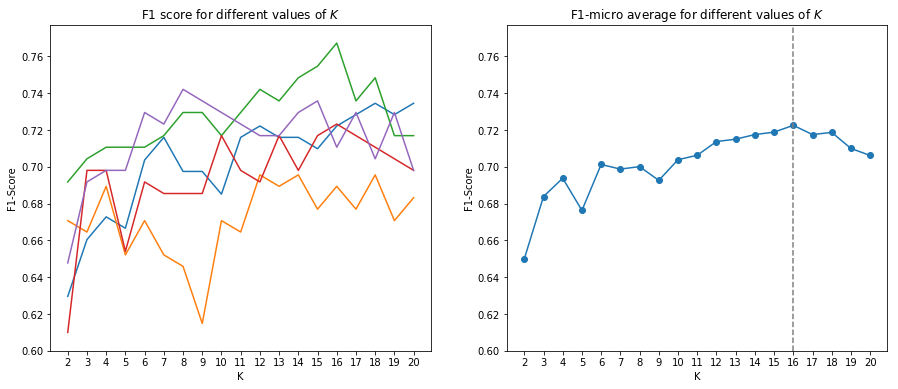

In [19]:
max_y1 = np.array(f1).max()
max_y2 = f1_means.max()
max_y = max(max_y1, max_y2)

min_y1 = np.array(f1).min()
min_y2 = f1_means.min()
min_y = min(min_y1, min_y2)

delta = 0.01
k_array = np.arange(min_k, max_k)
pos_max_f1 = np.where(f1_means == f1_means.max())[0][0]
best_k = k_array[pos_max_f1] - min_k

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.ylim(min_y-delta, max_y+delta)
plt.plot(f1, '-')
plt.xticks(np.arange(max_k - min_k), np.arange(min_k, max_k))
plt.title('F1 score for different values of $K$')
plt.xlabel('K')
plt.ylabel('F1-Score')
plt.subplot(1,2,2)
plt.ylim(min_y-delta, max_y+delta)
plt.plot(f1_means, 'o-')
plt.axvline(x=best_k, linestyle='--', color='grey')
plt.xticks(np.arange(max_k - min_k), np.arange(min_k, max_k))
plt.title('F1-micro average for different values of $K$')
plt.xlabel('K')
plt.ylabel('F1-Score')
plt.show();

### Distance metrics

In [20]:
f1 = []
metrics = ['euclidean','manhattan','chebyshev','haversine']
for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1, metric=metric)
    score = cross_val_score(knn, X.train, y.train, scoring='f1_micro', cv=5)
    f1.append(score)
f1_means = np.mean(np.array(f1), axis=1)

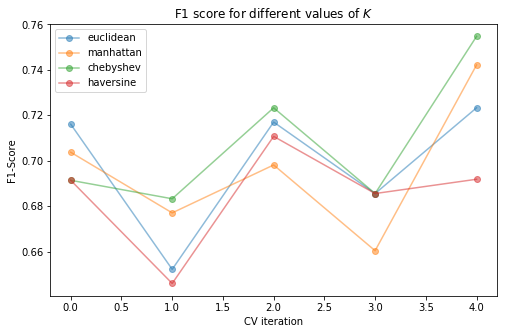

In [21]:
max_y1 = np.array(f1).max()
max_y2 = f1_means.max()
max_y = max(max_y1, max_y2)

min_y1 = np.array(f1).min()
min_y2 = f1_means.min()
min_y = min(min_y1, min_y2)

plt.figure(figsize=(8,5))
for i in range(len(metrics)):
    plt.plot(f1[i], 'o-', label=metrics[i], alpha=0.5)
plt.title('F1 score for different values of $K$')
plt.xlabel('CV iteration')
plt.ylabel('F1-Score')
plt.legend(loc='best')
plt.show();

Put everything together, we get no improvement...

In [22]:
X, y = oil.split()
X.train = X.train.iloc[:, 5:7]
X.test = X.test.iloc[:, 5:7]
n_neighbors=7
knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='chebyshev')
knn.fit(X.train.values, y.train.values)

#Predict the response for test dataset
y_pred = knn.predict(X.test.values)
# Model Accuracy, how often is the classifier correct?
print("F1:", f1_score(y.test, y_pred, average='micro'))

F1: 0.715


Thanks!